<a href="https://colab.research.google.com/github/dede0702/Olist-E-Commerce-Data-Analysis/blob/main/Brazilian_E_Commerce_Dataset_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📊 Análise de Dados de E-commerce Brasileiro

Neste projeto, exploramos o conjunto de dados "Brazilian E-Commerce Public Dataset by Olist", disponível no Kaggle. Este dataset contém informações sobre 100 mil pedidos realizados entre 2016 e 2018 em uma plataforma de e-commerce brasileira, abrangendo detalhes como produtos, clientes e avaliações.

O objetivo principal é analisar esses dados para extrair insights valiosos que possam informar decisões estratégicas em negócios de e-commerce.

Recursos utilizados:

* Repositório: [Desafio Técnico - Triggo.ai](https://github.com/Triggo-ai4/desafio-data-engineer.git)
* Dataset: [Brazilian E-Commerce Public Dataset by Olist - Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data)

Este projeto é uma aplicação prática do teste técnico do programa de trainee da [triggo.ai](https://triggo.ai/), focado em Engenharia de Dados e DataOps.

# Teste Técnico - Programa Trainee triggo.ai de Excelência em Engenharia de Dados e DataOps 2025



```
Importando bibliotecas necessárias
```



In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 # For SQL examples if needed, though pandasql can also be used
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Added for simpler model option
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import plotly.express as px
import plotly.graph_objects as go
from math import radians, sin, cos, sqrt, atan2 # For Haversine, if chosen



```
Definindo caminho dos datasets
```



In [30]:
data_path = 'olist/'  # Ajuste conforme o local onde os arquivos estão salvo



```
Carregando os datasets
```



In [31]:
print("Carregando datasets...")
customers = pd.read_csv(os.path.join(data_path, 'olist_customers_dataset.csv'))
geolocation = pd.read_csv(os.path.join(data_path, 'olist_geolocation_dataset.csv'))
order_items = pd.read_csv(os.path.join(data_path, 'olist_order_items_dataset.csv'))
order_payments = pd.read_csv(os.path.join(data_path, 'olist_order_payments_dataset.csv'))
order_reviews = pd.read_csv(os.path.join(data_path, 'olist_order_reviews_dataset.csv'))
orders = pd.read_csv(os.path.join(data_path, 'olist_orders_dataset.csv'))
products = pd.read_csv(os.path.join(data_path, 'olist_products_dataset.csv'))
sellers = pd.read_csv(os.path.join(data_path, 'olist_sellers_dataset.csv'))
product_category_name_translation = pd.read_csv(os.path.join(data_path, 'product_category_name_translation.csv'))
print("Datasets carregados.")

Carregando datasets...
Datasets carregados.




```
 ETAPA 1: PREPARAÇÃO DOS DADOS (25 pontos)
```



In [32]:
# Descrição dos Passos de Preparação dos Dados:
# 1. Carregamento dos Dados: Todos os arquivos CSV fornecidos são carregados em DataFrames pandas.
# 2. Limpeza Inicial:
#    - Remoção de duplicatas no DataFrame `orders`.
#    - Conversão de colunas de timestamp para o tipo datetime pandas para facilitar manipulações temporais.
# 3. Normalização e Enriquecimento:
#    - Tradução dos Nomes das Categorias de Produtos: O DataFrame `product_category_name_translation` é usado para mapear os nomes das categorias de produtos para o inglês, padronizando-os. Isso é feito mesclando `products` com `product_category_name_translation`.
#    - Criação de um DataFrame Consolidado (`orders_details_df`): Para facilitar as análises, um DataFrame mais abrangente é criado através de uma série de merges:
#        - `orders` é o DataFrame base.
#        - `order_items` é mesclado para adicionar detalhes dos itens de cada pedido (produto, vendedor, preço, frete).
#        - O DataFrame `products` (já com categorias traduzidas) é mesclado para adicionar informações dos produtos.
#        - `customers` é mesclado para adicionar dados demográficos dos clientes.
#        - `order_payments` é mesclado para adicionar detalhes de pagamento.
#        - `order_reviews` é mesclado para adicionar as avaliações dos pedidos.
#    - Tratamento de Valores Nulos:
#        - Para colunas cruciais em merges ou cálculos (ex: `total_price`), valores nulos podem ser preenchidos ou as linhas removidas, dependendo do contexto da análise. Muitas análises subsequentes usam `dropna()` localmente.
#        - Colunas como `order_delivered_customer_date` podem ter Nulos (pedidos não entregues); isso é tratado na criação de features como `delivery_time_days`.
# 4. Criação de Novas Features (Engenharia de Features):
#    - `delivery_time_days`: Calculado como a diferença entre a data de entrega ao cliente e a data da compra.
#    - `is_late`: Uma flag booleana (convertida para int) indicando se o pedido foi entregue após a data estimada.
#    - `estimated_vs_actual_delivery_days_diff`: Diferença entre data estimada e data real de entrega.
#    - `time_to_approve_days`: Tempo entre a compra e a aprovação do pagamento.
#    - `product_volume_cm3`: Volume do produto.
# 5. Modelo Relacional e Conexões:
#    - As tabelas CSV originais representam um modelo relacional. As chaves primárias/estrangeiras (ex: `order_id`, `customer_id`, `product_id`, `seller_id`) são usadas nas operações de `pd.merge` para conectar as tabelas, simulando JOINs em SQL. O `orders_details_df` é efetivamente uma visão denormalizada desses dados unidos.
print("\n--- ETAPA 1: PREPARAÇÃO DOS DADOS ---")


--- ETAPA 1: PREPARAÇÃO DOS DADOS ---


In [33]:
# Limpeza e Conversão de Tipos em 'orders'
orders.drop_duplicates(inplace=True)
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
             'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce') # errors='coerce' will turn unparseable dates into NaT

In [34]:
# Normalização: Traduzir nomes de categorias de produtos
products = pd.merge(products, product_category_name_translation, on='product_category_name', how='left')
products.drop(columns=['product_category_name'], inplace=True) # Manter apenas a traduzida
products.rename(columns={'product_category_name_english': 'category_en'}, inplace=True)

In [35]:
# Criar DataFrame consolidado (orders_details_df)
print("Criando DataFrame consolidado 'orders_details_df'...")
df = orders.copy()
df = pd.merge(df, order_items, on='order_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')
df = pd.merge(df, order_payments, on='order_id', how='left') # Pode criar duplicatas se um pedido tiver múltiplos pagamentos
# Para order_reviews, é melhor agregar antes ou juntar com cuidado, pois um pedido pode ter múltiplas avaliações (raro, mas possível) ou nenhuma.
# Para a maioria dos casos, uma junção 'left' com a avaliação principal ou média é suficiente.
# Agregando reviews para ter uma nota por pedido
avg_review_score_per_order = order_reviews.groupby('order_id')['review_score'].mean().reset_index()
df = pd.merge(df, avg_review_score_per_order, on='order_id', how='left')

Criando DataFrame consolidado 'orders_details_df'...


In [36]:
# Engenharia de Features
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['estimated_delivery_time_days'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days
df['is_late'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)
df['estimated_vs_actual_delivery_days_diff'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['time_to_approve_days'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / (24 * 60 * 60)
df['product_volume_cm3'] = df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']

In [37]:
# Tratar valores nulos (exemplo para colunas chave, mais tratamento pode ser feito ad-hoc)
df['price'].fillna(0, inplace=True) # Preço do item
df['freight_value'].fillna(0, inplace=True) # Frete do item
df['payment_value'].fillna(df.groupby('order_id')['payment_value'].transform('sum').fillna(0), inplace=True) # Valor total do pagamento do pedido

<ipython-input-37-83fa9abace7c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(0, inplace=True) # Preço do item
<ipython-input-37-83fa9abace7c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [38]:
# Como order_payments pode ter múltiplas linhas por pedido (ex: boleto + voucher), agregamos o valor do pagamento por pedido
# Se df já foi merged com order_payments e isso causou duplicação de linhas de itens, precisamos ter cuidado.
# Assumindo que o merge com order_payments foi feito de forma a representar o valor total do pedido,
# ou que 'price' e 'freight_value' são por item e 'payment_value' é o valor da transação de pagamento específica.
# Para faturamento por item, 'price' é o correto. Para valor total do pedido, precisamos agregar 'price' e 'freight_value' de order_items.
order_value_agg = order_items.groupby('order_id').agg(
    total_items_price=('price', 'sum'),
    total_freight_value=('freight_value', 'sum')
).reset_index()
order_value_agg['total_order_value'] = order_value_agg['total_items_price'] + order_value_agg['total_freight_value']

In [39]:
# Removendo colunas de valor agregado do df principal se já existem, para evitar confusão, e depois juntando as novas agregações
cols_to_drop_for_merge = ['total_items_price', 'total_freight_value', 'total_order_value']
df = df.drop(columns=[col for col in cols_to_drop_for_merge if col in df.columns], errors='ignore')
df = pd.merge(df, order_value_agg, on='order_id', how='left')

In [40]:
# Lidando com múltiplas formas de pagamento para um mesmo pedido:
# Se o merge com order_payments criou múltiplas linhas para o mesmo item de pedido (se um pedido tiver vários itens e vários pagamentos),
# as análises de faturamento devem usar `order_items.price` e agregar.
# O `df` atual pode ter linhas duplicadas se um pedido tiver múltiplos itens E/OU múltiplos pagamentos.
# Vamos criar um `orders_main_df` que seja único por pedido para análises no nível do pedido.
orders_main_df = orders.copy()
orders_main_df = pd.merge(orders_main_df, order_value_agg, on='order_id', how='left')
orders_main_df = pd.merge(orders_main_df, customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']], on='customer_id', how='left')
orders_main_df = pd.merge(orders_main_df, avg_review_score_per_order, on='order_id', how='left')
# Adicionar features de tempo calculadas anteriormente no 'orders'
orders_main_df['delivery_time_days'] = (orders_main_df['order_delivered_customer_date'] - orders_main_df['order_purchase_timestamp']).dt.days
orders_main_df['estimated_delivery_time_days'] = (orders_main_df['order_estimated_delivery_date'] - orders_main_df['order_purchase_timestamp']).dt.days
orders_main_df['is_late'] = (orders_main_df['order_delivered_customer_date'] > orders_main_df['order_estimated_delivery_date']).astype(int)
orders_main_df['estimated_vs_actual_delivery_days_diff'] = (orders_main_df['order_estimated_delivery_date'] - orders_main_df['order_delivered_customer_date']).dt.days
orders_main_df['time_to_approve_days'] = (orders_main_df['order_approved_at'] - orders_main_df['order_purchase_timestamp']).dt.total_seconds() / (24 * 60 * 60)

In [41]:
# Para análises que envolvem detalhes de itens/produtos, usar 'df' (o mais granular).
# Para análises a nível de pedido, usar 'orders_main_df'.
orders_details_df = df.copy() # Renomeando df para clareza
print(f"DataFrame consolidado 'orders_details_df' criado com {orders_details_df.shape[0]} linhas (pode ter duplicatas por item/pagamento).")
print(f"DataFrame 'orders_main_df' (único por pedido) criado com {orders_main_df.shape[0]} linhas.")
print("Preparação de dados concluída.")

DataFrame consolidado 'orders_details_df' criado com 118434 linhas (pode ter duplicatas por item/pagamento).
DataFrame 'orders_main_df' (único por pedido) criado com 99441 linhas.
Preparação de dados concluída.




```
ETAPA 2: ANÁLISE EXPLORATÓRIA DE DADOS (25 pontos)
```



In [42]:
print("\n--- ETAPA 2: ANÁLISE EXPLORATÓRIA DE DADOS ---")


--- ETAPA 2: ANÁLISE EXPLORATÓRIA DE DADOS ---



2a) Volume de pedidos por mês:


<ipython-input-43-9be2da54f0aa>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = orders_main_df.set_index('order_purchase_timestamp').resample('M')['order_id'].count()


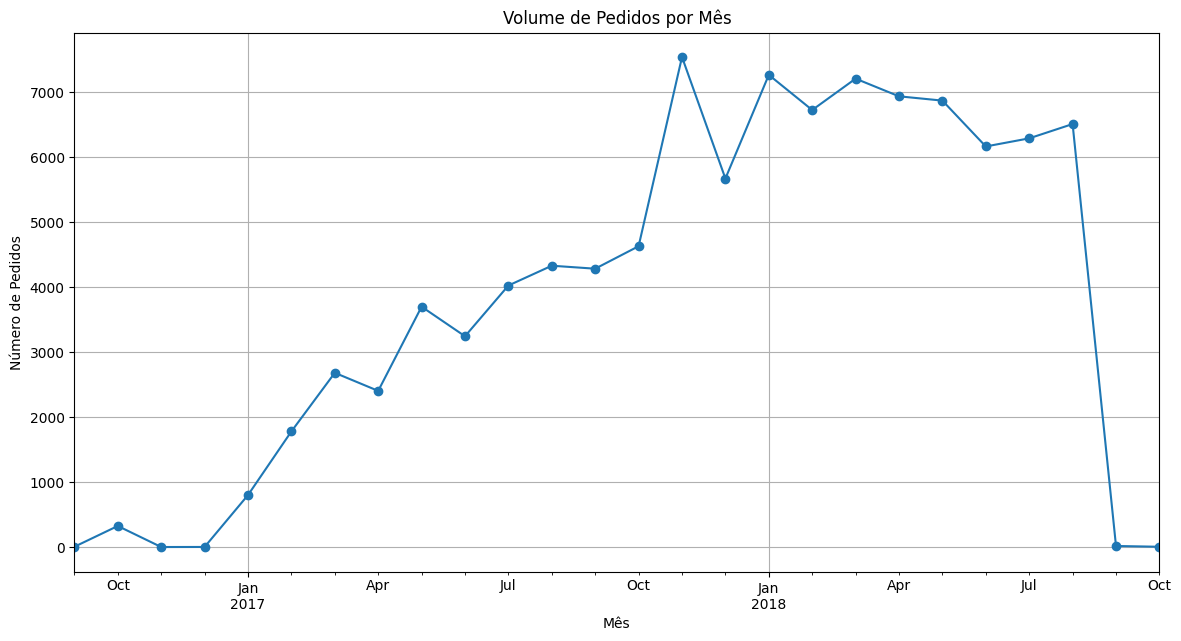

Sazonalidade: Observando o gráfico, podemos procurar por padrões repetitivos anuais.
Picos de vendas podem ocorrer em datas comemorativas (ex: Natal em Dezembro, Black Friday em Novembro).
Vales podem indicar meses de menor consumo. Os dados de 2016 e final de 2018 são parciais, o que pode afetar a análise de sazonalidade completa.
O pico de pedidos ocorreu em: 2017-11 com 7544 pedidos.


In [43]:
# a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?
# Pandas: orders_main_df.groupby(pd.Grouper(key='order_purchase_timestamp', freq='M')).size()
# SQL: SELECT strftime('%Y-%m', order_purchase_timestamp) as month_year, COUNT(order_id) FROM orders_main_df GROUP BY month_year;
print("\n2a) Volume de pedidos por mês:")
monthly_orders = orders_main_df.set_index('order_purchase_timestamp').resample('M')['order_id'].count()
plt.figure(figsize=(14, 7))
monthly_orders.plot(kind='line', marker='o')
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()
print("Sazonalidade: Observando o gráfico, podemos procurar por padrões repetitivos anuais.")
print("Picos de vendas podem ocorrer em datas comemorativas (ex: Natal em Dezembro, Black Friday em Novembro).")
print("Vales podem indicar meses de menor consumo. Os dados de 2016 e final de 2018 são parciais, o que pode afetar a análise de sazonalidade completa.")
# Verificando picos
peak_month = monthly_orders.idxmax()
peak_value = monthly_orders.max()
print(f"O pico de pedidos ocorreu em: {peak_month.strftime('%Y-%m')} com {peak_value} pedidos.")
# Para uma análise de sazonalidade mais robusta, seriam necessários mais anos de dados ou técnicas de decomposição de séries temporais.


2b) Distribuição do tempo de entrega dos pedidos:


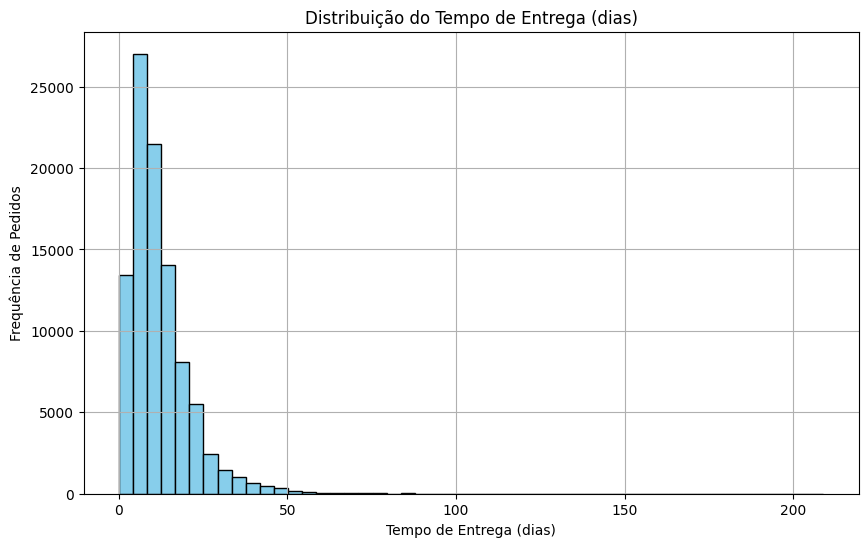

Estatísticas do tempo de entrega:
count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time_days, dtype: float64
A maioria dos pedidos é entregue em até ~30 dias, com uma cauda longa de entregas mais demoradas.


In [44]:
# b) Qual a distribuição do tempo de entrega dos pedidos?
# Pandas: orders_main_df['delivery_time_days'].dropna().hist()
# SQL: (Mais complexo em SQL puro, geralmente feito na aplicação após query)
print("\n2b) Distribuição do tempo de entrega dos pedidos:")
plt.figure(figsize=(10,6))
plt.hist(orders_main_df['delivery_time_days'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega (dias)')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Frequência de Pedidos')
plt.grid(True)
plt.show()
print(f"Estatísticas do tempo de entrega:\n{orders_main_df['delivery_time_days'].describe()}")
print("A maioria dos pedidos é entregue em até ~30 dias, com uma cauda longa de entregas mais demoradas.")



2c) Relação entre valor do frete e proxy de localização do cliente (latitude média)...


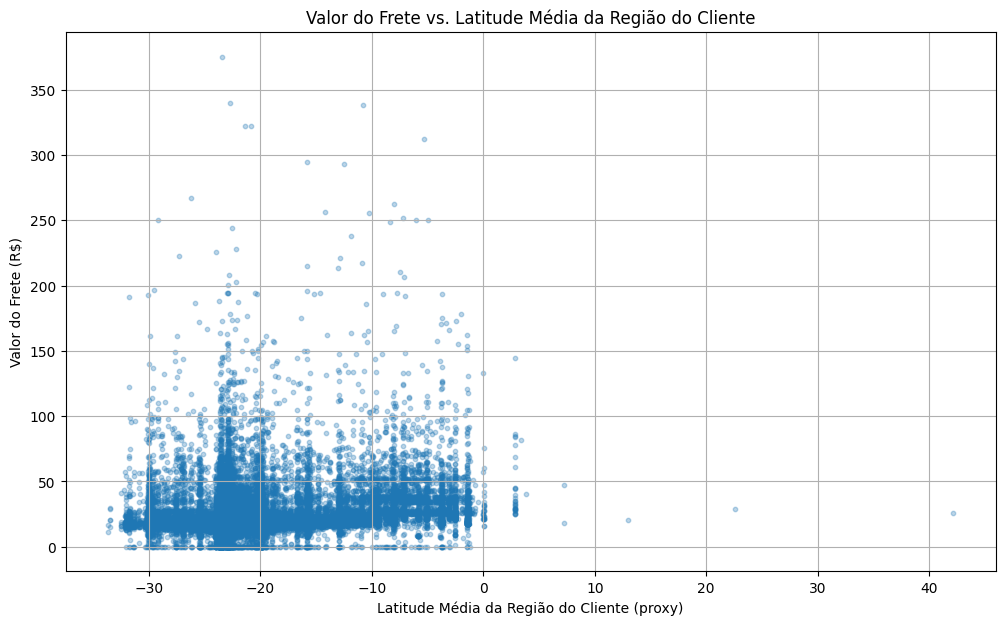

Analisar este gráfico pode indicar se fretes são mais caros para regiões mais distantes (ao norte/sul do centro de distribuição presumido).
Lembre-se que latitude é apenas uma proxy e não representa a distância real da entrega.


In [45]:
# c) Qual a relação entre o valor do frete e a distância de entrega? (Usando proxy de latitude do cliente)
# Pandas: Merges para obter localizações e scatter plot.
# SQL: (Envolveria JOINs e talvez funções geoespaciais se disponíveis no SGBD)
print("\n2c) Relação entre valor do frete e proxy de localização do cliente (latitude média)...")
geo_agg_customer = geolocation.groupby('geolocation_zip_code_prefix').agg(
    customer_mean_lat=('geolocation_lat', 'mean'),
    customer_mean_lng=('geolocation_lng', 'mean')
).reset_index()

# Usaremos orders_details_df pois freight_value está lá por item.
# Se o frete for por pedido, agregar freight_value em orders_main_df primeiro.
# Assumindo freight_value é por item no order_items:
df_freight_dist_analysis = pd.merge(orders_details_df[['order_id', 'customer_zip_code_prefix', 'freight_value']].drop_duplicates(),
                                    geo_agg_customer,
                                    left_on='customer_zip_code_prefix',
                                    right_on='geolocation_zip_code_prefix',
                                    how='left')
df_freight_dist_analysis.dropna(subset=['freight_value', 'customer_mean_lat'], inplace=True)

if not df_freight_dist_analysis.empty:
    sample_size = min(50000, len(df_freight_dist_analysis))
    df_sample = df_freight_dist_analysis.sample(n=sample_size, random_state=42)

    plt.figure(figsize=(12, 7))
    plt.scatter(df_sample['customer_mean_lat'], df_sample['freight_value'], alpha=0.3, s=10)
    plt.title('Valor do Frete vs. Latitude Média da Região do Cliente')
    plt.xlabel('Latitude Média da Região do Cliente (proxy)')
    plt.ylabel('Valor do Frete (R$)')
    plt.grid(True)
    plt.show()
else:
    print("Não há dados suficientes para plotar a relação frete vs. localização do cliente.")
print("Analisar este gráfico pode indicar se fretes são mais caros para regiões mais distantes (ao norte/sul do centro de distribuição presumido).")
print("Lembre-se que latitude é apenas uma proxy e não representa a distância real da entrega.")



2d) Categorias de produtos mais vendidas (faturamento):


<ipython-input-46-6576fb074b6a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_category.head(top_n_categories), x='total_revenue', y='category_en', palette='viridis')


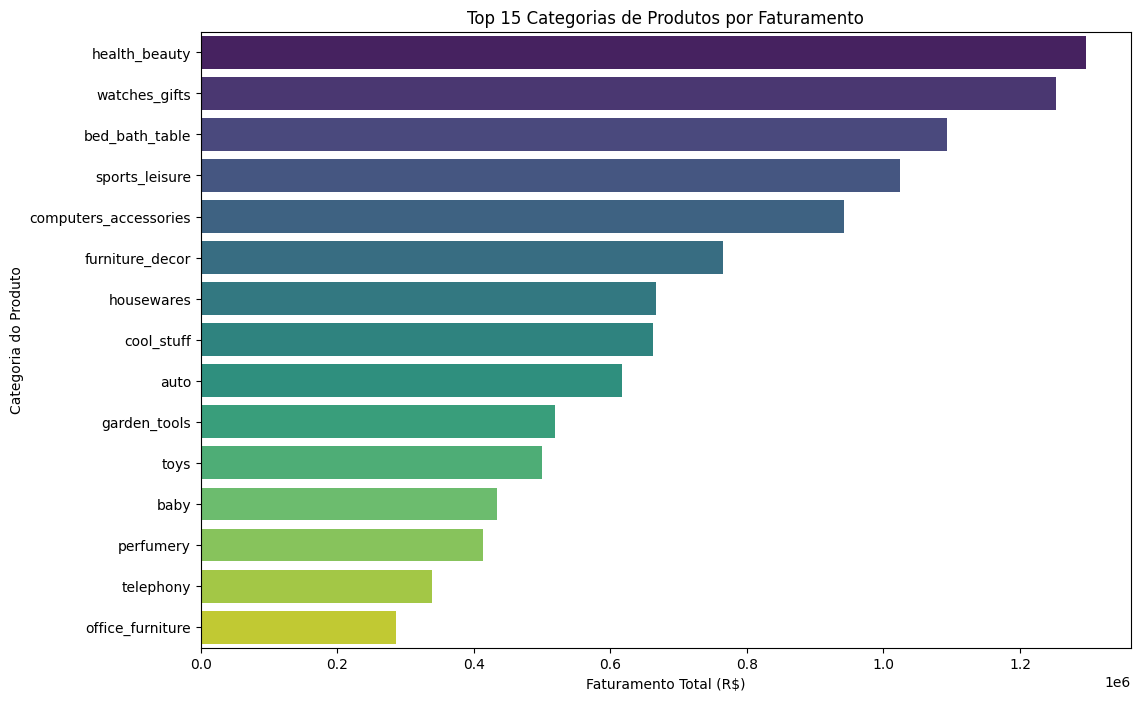

              category_en  total_revenue
0           health_beauty     1297490.77
1           watches_gifts     1253143.30
2          bed_bath_table     1092551.02
3          sports_leisure     1023996.34
4   computers_accessories      942277.57
5         furniture_decor      765093.89
6              housewares      666587.00
7              cool_stuff      662309.49
8                    auto      616752.51
9            garden_tools      518217.54
10                   toys      500295.09
11                   baby      434479.61
12              perfumery      412754.81
13              telephony      339399.16
14       office_furniture      286158.96


In [46]:
# d) Quais são as categorias de produtos mais vendidas em termos de faturamento?
# Pandas: orders_details_df.groupby('category_en')['price'].sum().sort_values(ascending=False)
# SQL: SELECT category_en, SUM(price) as total_revenue FROM orders_details_df GROUP BY category_en ORDER BY total_revenue DESC;
print("\n2d) Categorias de produtos mais vendidas (faturamento):")
# Usando 'orders_details_df' que tem 'price' por item e 'category_en'
revenue_by_category = orders_details_df.groupby('category_en')['price'].sum().sort_values(ascending=False).reset_index()
revenue_by_category.rename(columns={'price': 'total_revenue'}, inplace=True)

# Remover categorias com poucos dados ou NaNs se existirem
revenue_by_category.dropna(subset=['category_en', 'total_revenue'], inplace=True)

if not revenue_by_category.empty:
    top_n_categories = 15
    plt.figure(figsize=(12, 8))
    sns.barplot(data=revenue_by_category.head(top_n_categories), x='total_revenue', y='category_en', palette='viridis')
    plt.title(f'Top {top_n_categories} Categorias de Produtos por Faturamento')
    plt.xlabel('Faturamento Total (R$)')
    plt.ylabel('Categoria do Produto')
    plt.show()
    print(revenue_by_category.head(top_n_categories))
else:
    print("Não há dados de faturamento por categoria.")



2e) Estados brasileiros com maior valor médio de pedido:


<ipython-input-47-9b7ebbf13db4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_order_value_by_state.head(top_n_states), x='total_order_value', y='customer_state', palette='coolwarm')


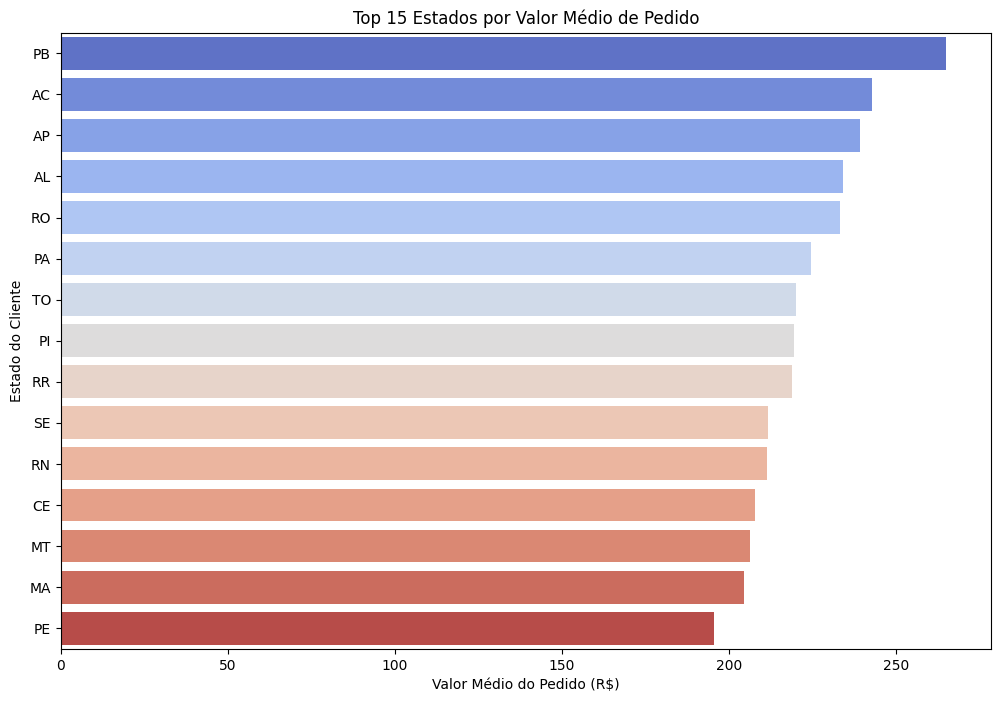

   customer_state  total_order_value
0              PB         265.014680
1              AC         242.835802
2              AP         239.158824
3              AL         234.134793
4              RO         233.028421
5              PA         224.378464
6              TO         219.908315
7              PI         219.335254
8              RR         218.796087
9              SE         211.687884
10             RN         211.400581
11             CE         207.691258
12             MT         206.167176
13             MA         204.286473
14             PE         195.532579


In [47]:
# e) Quais estados brasileiros possuem o maior valor médio de pedido?
# Pandas: orders_main_df.groupby('customer_state')['total_order_value'].mean().sort_values(ascending=False)
# SQL: SELECT customer_state, AVG(total_order_value) as avg_order_value FROM orders_main_df GROUP BY customer_state ORDER BY avg_order_value DESC;
print("\n2e) Estados brasileiros com maior valor médio de pedido:")
# Usando 'orders_main_df' que tem 'total_order_value' (agregado por pedido) e 'customer_state'
avg_order_value_by_state = orders_main_df.groupby('customer_state')['total_order_value'].mean().sort_values(ascending=False).reset_index()
avg_order_value_by_state.dropna(inplace=True)

if not avg_order_value_by_state.empty:
    top_n_states = 15
    plt.figure(figsize=(12, 8))
    sns.barplot(data=avg_order_value_by_state.head(top_n_states), x='total_order_value', y='customer_state', palette='coolwarm')
    plt.title(f'Top {top_n_states} Estados por Valor Médio de Pedido')
    plt.xlabel('Valor Médio do Pedido (R$)')
    plt.ylabel('Estado do Cliente')
    plt.show()
    print(avg_order_value_by_state.head(top_n_states))
else:
    print("Não há dados de valor médio de pedido por estado.")



```
ETAPA 3: SOLUÇÃO DE PROBLEMAS DE NEGÓCIO
```



In [48]:
print("\n--- ETAPA 3: SOLUÇÃO DE PROBLEMAS DE NEGÓCIO ---")


--- ETAPA 3: SOLUÇÃO DE PROBLEMAS DE NEGÓCIO ---




```
3.1 - Análise de Retenção
```



In [49]:
print("\n3.1) Análise de Retenção:")
# Um cliente recorrente é aquele que fez mais de um pedido. Usamos 'customer_unique_id' para rastrear o cliente ao longo do tempo.
customer_order_counts = orders_main_df.groupby('customer_unique_id')['order_id'].count().reset_index(name='num_orders')
customer_order_counts['is_recurrent'] = customer_order_counts['num_orders'] > 1
recurrence_rate = customer_order_counts['is_recurrent'].mean()
print(f"Taxa de Clientes Recorrentes (baseado em 'customer_unique_id'): {recurrence_rate:.2%}")

total_unique_customers = customer_order_counts['customer_unique_id'].nunique()
recurrent_customers_count = customer_order_counts[customer_order_counts['is_recurrent']]['customer_unique_id'].nunique()
print(f"Total de clientes únicos: {total_unique_customers}")
print(f"Número de clientes recorrentes: {recurrent_customers_count}")

print("\nInsights da Análise de Retenção:")
print(f"- A taxa de recorrência de {recurrence_rate:.2%} indica a proporção de clientes que voltaram a comprar.")
print("- Uma baixa taxa de recorrência pode sugerir que a maioria dos clientes faz uma única compra. Estratégias para aumentar a lealdade podem ser necessárias.")
print("- Investigar o perfil dos clientes recorrentes (categorias que compram, valor médio do pedido, satisfação) pode revelar o que os faz retornar.")
print("- Comparar a taxa de recorrência ao longo do tempo ou entre diferentes cohorts de aquisição pode mostrar a efetividade de ações de retenção.")


3.1) Análise de Retenção:
Taxa de Clientes Recorrentes (baseado em 'customer_unique_id'): 3.12%
Total de clientes únicos: 96096
Número de clientes recorrentes: 2997

Insights da Análise de Retenção:
- A taxa de recorrência de 3.12% indica a proporção de clientes que voltaram a comprar.
- Uma baixa taxa de recorrência pode sugerir que a maioria dos clientes faz uma única compra. Estratégias para aumentar a lealdade podem ser necessárias.
- Investigar o perfil dos clientes recorrentes (categorias que compram, valor médio do pedido, satisfação) pode revelar o que os faz retornar.
- Comparar a taxa de recorrência ao longo do tempo ou entre diferentes cohorts de aquisição pode mostrar a efetividade de ações de retenção.




```
 3.2 - Predição de Atraso
```




3.2) Predição de Atraso:
Tamanho do conjunto de treino: 66579, Teste: 28534

Relatório de Classificação (Predição de Atraso):
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     26222
           1       0.13      0.63      0.22      2312

    accuracy                           0.64     28534
   macro avg       0.54      0.64      0.49     28534
weighted avg       0.89      0.64      0.72     28534

Acurácia: 0.6408

Matriz de Confusão:


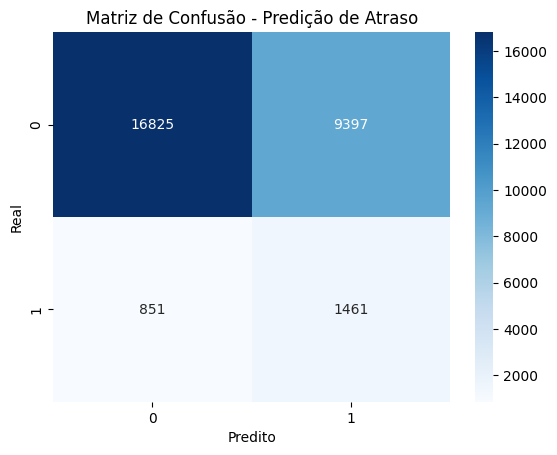


Explicação dos Resultados da Predição de Atraso:
- Acurácia: Proporção de previsões corretas. Pode ser enganosa se as classes forem desbalanceadas.
- Precisão (Precision): Dos que foram previstos como 'atrasados', quantos realmente o foram. Importante se o custo de um falso positivo for alto.
- Recall (Sensibilidade): Dos que realmente foram 'atrasados', quantos o modelo conseguiu prever. Importante se o custo de um falso negativo for alto (não prever um atraso real).
- F1-Score: Média harmônica entre precisão e recall. Bom para classes desbalanceadas.
- O modelo atual é simples. Para melhorar: mais features, engenharia de features mais complexa (ex: distância real, dados do vendedor), ajuste de hiperparâmetros, modelos mais sofisticados.
- A classe 'atrasado' (1) pode ser minoritária (y.value_counts(normalize=True)). O `class_weight='balanced'` tenta mitigar isso.


In [50]:
print("\n3.2) Predição de Atraso:")
# Definindo pedido atrasado: order_delivered_customer_date > order_estimated_delivery_date (já calculado como 'is_late')
# Features para o modelo:
# Usaremos `orders_main_df` que é único por pedido.
delay_prediction_df = orders_main_df.copy()

# Selecionar features relevantes e tratar NaNs
# Features numéricas:
num_features = ['estimated_delivery_time_days', 'time_to_approve_days', 'total_order_value', 'total_freight_value']
# Features categóricas (precisam ser codificadas):
# Para simplicidade, vamos pegar as mais impactantes e com cardinalidade gerenciável
cat_features = ['order_status', 'customer_state'] # Adicionar mais se necessário, ex: payment_type (do df.order_payments)

# Adicionar features de produto (ex: peso médio, volume médio por pedido, categoria predominante)
# Para isso, precisamos agregar de orders_details_df para orders_main_df
product_features_agg = orders_details_df.groupby('order_id').agg(
    avg_product_weight_g=('product_weight_g', 'mean'),
    avg_product_volume_cm3=('product_volume_cm3', 'mean'),
    # Para categoria, podemos pegar a mais frequente ou a do item mais caro
    # Aqui pegamos a primeira categoria (simplificação)
    main_category=('category_en', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

delay_prediction_df = pd.merge(delay_prediction_df, product_features_agg, on='order_id', how='left')
cat_features.append('main_category') # Adiciona a nova feature categórica
num_features.extend(['avg_product_weight_g', 'avg_product_volume_cm3'])


target = 'is_late'
features = num_features + cat_features

# Filtrar apenas pedidos que foram entregues para ter 'is_late' definido corretamente
delay_prediction_df = delay_prediction_df[delay_prediction_df['order_status'] == 'delivered']
delay_prediction_df = delay_prediction_df[features + [target]].dropna()


if not delay_prediction_df.empty and len(delay_prediction_df) > 100: # Minimo de amostras
    X = delay_prediction_df[features]
    y = delay_prediction_df[target]

    # Preprocessing: OneHotEncode para categóricas, StandardScaler para numéricas
    # Separar colunas numericas e categoricas
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Trata NaNs em numéricas
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Trata NaNs em categóricas
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False para RandomForest
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # Modelo: RandomForestClassifier
    # model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
    #                                ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))]) # class_weight para lidar com desbalanceamento
    # Usando Logistic Regression para um modelo mais simples como solicitado
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, solver='liblinear'))])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Tamanho do conjunto de treino: {X_train.shape[0]}, Teste: {X_test.shape[0]}")
    if X_train.shape[0] > 0 and X_test.shape[0] > 0:
        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_test)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:,1] # Probabilidade de ser 'atrasado'

        print("\nRelatório de Classificação (Predição de Atraso):")
        print(classification_report(y_test, y_pred))
        print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")

        print("\nMatriz de Confusão:")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusão - Predição de Atraso')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

        print("\nExplicação dos Resultados da Predição de Atraso:")
        print("- Acurácia: Proporção de previsões corretas. Pode ser enganosa se as classes forem desbalanceadas.")
        print("- Precisão (Precision): Dos que foram previstos como 'atrasados', quantos realmente o foram. Importante se o custo de um falso positivo for alto.")
        print("- Recall (Sensibilidade): Dos que realmente foram 'atrasados', quantos o modelo conseguiu prever. Importante se o custo de um falso negativo for alto (não prever um atraso real).")
        print("- F1-Score: Média harmônica entre precisão e recall. Bom para classes desbalanceadas.")
        print("- O modelo atual é simples. Para melhorar: mais features, engenharia de features mais complexa (ex: distância real, dados do vendedor), ajuste de hiperparâmetros, modelos mais sofisticados.")
        print(f"- A classe 'atrasado' (1) pode ser minoritária (y.value_counts(normalize=True)). O `class_weight='balanced'` tenta mitigar isso.")
    else:
        print("Não há dados suficientes para treinar/testar o modelo de predição de atraso após o split.")
else:
    print("Não há dados suficientes para o modelo de predição de atraso (menos de 100 amostras ou dados vazios após limpeza).")



```
3.3 - Segmentação de Clientes
```




3.3) Segmentação de Clientes:


<ipython-input-52-55e66a412786>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_agg_data['avg_review_score'].fillna(customer_agg_data['avg_review_score'].median(), inplace=True)


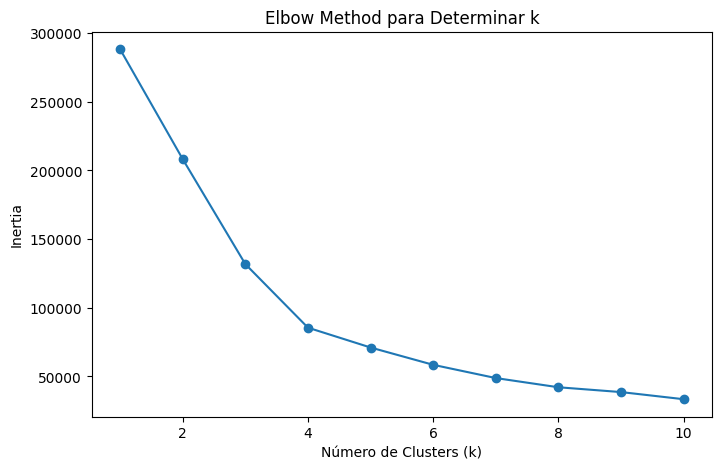


Características médias dos segmentos de clientes (k=4):
         monetary_value  frequency  avg_review_score
segment                                             
0            132.053744   1.000000          4.749875
1           1204.872195   1.016017          4.056494
2            142.665710   1.000000          1.860789
3            285.940226   2.116436          4.119073


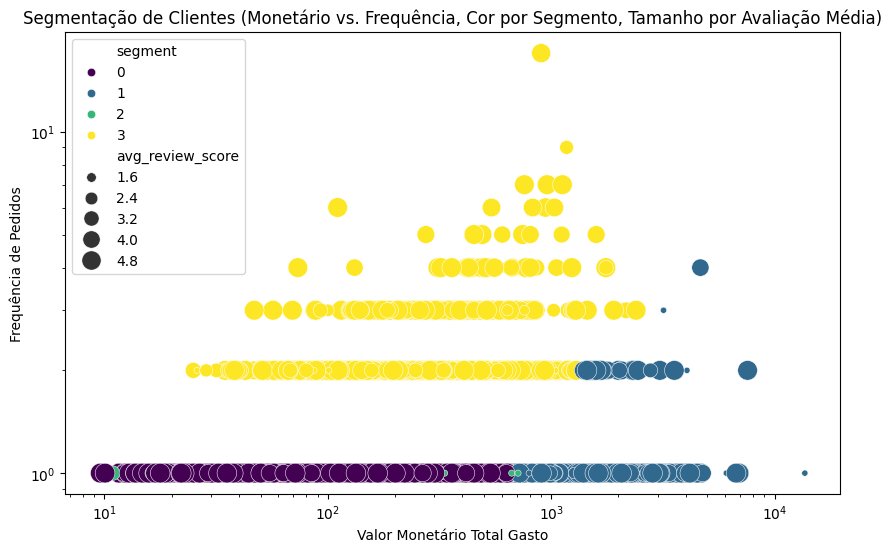


Análise dos Segmentos e Estratégias de Marketing Sugeridas:
- Segmento Campeão (Alto Valor, Alta Frequência, Alta Avaliação): Clientes leais e valiosos. Programas VIP, acesso antecipado a produtos, agradecimentos personalizados.
- Segmento Promissor (Valor/Frequência Moderados, Boa Avaliação): Potencial para se tornarem campeões. Campanhas de engajamento, ofertas personalizadas para aumentar frequência/valor, programas de fidelidade.
- Segmento de Risco/Atenção (Baixo Valor/Frequência, Baixa Avaliação ou Mista): Entender motivos de insatisfação (pesquisas). Campanhas de reativação, ofertas especiais para incentivar nova compra, melhoria de atendimento se a avaliação for baixa.
- Segmento Novo/Ocasional (Baixo Valor, Baixa Frequência, Avaliação Variada): Foco em aumentar o engajamento e a primeira experiência positiva. Welcome kits, tutoriais de produtos, recomendações baseadas na primeira compra.
A interpretação exata dos segmentos depende dos centróides obtidos.


In [52]:
print("\n3.3) Segmentação de Clientes:")
# Usaremos 'customer_unique_id'. Agregaremos:
# - Valor total gasto (Monetary)
# - Frequência de pedidos (Frequency)
# - Média de avaliação dada (Average Review Score)
# - Recência (não implementada aqui para simplificar, mas seria importante para RFM)

customer_agg_data = orders_main_df.groupby('customer_unique_id').agg(
    monetary_value=('total_order_value', 'sum'),
    frequency=('order_id', 'count'),
    avg_review_score=('review_score', 'mean')
).reset_index()

# Tratar NaNs que podem surgir da média de review_score (se cliente não deu review)
customer_agg_data['avg_review_score'].fillna(customer_agg_data['avg_review_score'].median(), inplace=True)
customer_agg_data.dropna(subset=['monetary_value', 'frequency'], inplace=True) # Garantir que valores chave não são nulos

if customer_agg_data.shape[0] >= 5: # KMeans precisa de amostras suficientes
    features_for_clustering = ['monetary_value', 'frequency', 'avg_review_score']
    X_cluster = customer_agg_data[features_for_clustering]

    # Escalonar os dados antes do KMeans
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster)

    # Determinar número de clusters (ex: usando Elbow Method - visualmente aqui, ou via código)
    inertia = []
    for k in range(1, 11):
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_test.fit(X_cluster_scaled)
        inertia.append(kmeans_test.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Method para Determinar k')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()
    # Baseado no elbow, escolher k (ex: 3 ou 4)

    n_clusters = 4 # Escolhido após análise do Elbow (ou arbitrariamente para o exercício)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    customer_agg_data['segment'] = kmeans.fit_predict(X_cluster_scaled)

    print(f"\nCaracterísticas médias dos segmentos de clientes (k={n_clusters}):")
    segment_analysis = customer_agg_data.groupby('segment')[features_for_clustering].mean()
    print(segment_analysis)

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=customer_agg_data, x='monetary_value', y='frequency', hue='segment', palette='viridis', size='avg_review_score', sizes=(20,200))
    plt.title('Segmentação de Clientes (Monetário vs. Frequência, Cor por Segmento, Tamanho por Avaliação Média)')
    plt.xlabel('Valor Monetário Total Gasto')
    plt.ylabel('Frequência de Pedidos')
    plt.xscale('log') # Log scale para melhor visualização de monetário se muito disperso
    plt.yscale('log') # Se frequência também for muito dispersa
    plt.show()

    print("\nAnálise dos Segmentos e Estratégias de Marketing Sugeridas:")
    # Esta análise é genérica, baseada nos nomes das features.
    # Exemplo para 4 clusters:
    print("- Segmento Campeão (Alto Valor, Alta Frequência, Alta Avaliação): Clientes leais e valiosos. Programas VIP, acesso antecipado a produtos, agradecimentos personalizados.")
    print("- Segmento Promissor (Valor/Frequência Moderados, Boa Avaliação): Potencial para se tornarem campeões. Campanhas de engajamento, ofertas personalizadas para aumentar frequência/valor, programas de fidelidade.")
    print("- Segmento de Risco/Atenção (Baixo Valor/Frequência, Baixa Avaliação ou Mista): Entender motivos de insatisfação (pesquisas). Campanhas de reativação, ofertas especiais para incentivar nova compra, melhoria de atendimento se a avaliação for baixa.")
    print("- Segmento Novo/Ocasional (Baixo Valor, Baixa Frequência, Avaliação Variada): Foco em aumentar o engajamento e a primeira experiência positiva. Welcome kits, tutoriais de produtos, recomendações baseadas na primeira compra.")
    print("A interpretação exata dos segmentos depende dos centróides obtidos.")

else:
    print("Não há dados suficientes para segmentação de clientes robusta (mínimo 5 clientes necessários).")



```
3.4) Análise de Satisfação
```



In [ ]:
print("\n3.4) Análise de Satisfação:")
# Usaremos `orders_details_df` para ter `review_score` e outros detalhes.
# Removemos pedidos sem avaliação
satisfaction_df = orders_details_df.dropna(subset=['review_score'])

# Relação entre nota e tempo de entrega (já feito com boxplot e scatter em Etapa 2 e 4)
plt.figure(figsize=(10,6))
sns.boxplot(data=satisfaction_df, x='review_score', y='delivery_time_days', palette='coolwarm_r')
plt.title('Tempo de Entrega (dias) vs. Nota de Avaliação')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Tempo de Entrega (dias)')
plt.ylim(0, satisfaction_df['delivery_time_days'].quantile(0.95)) # Limitar eixo y para melhor visualização
plt.grid(True)
plt.show()
print("Conforme esperado, tempos de entrega menores tendem a estar associados a notas de avaliação mais altas.")

# Relação entre nota e categoria do produto
if 'category_en' in satisfaction_df.columns:
    plt.figure(figsize=(12, 8))
    # Considerar apenas categorias com um número mínimo de avaliações para um boxplot mais estável
    category_counts = satisfaction_df['category_en'].value_counts()
    common_categories = category_counts[category_counts > 50].index # Ex: min 50 avaliações

    if not common_categories.empty:
        filtered_satisfaction_df_cat = satisfaction_df[satisfaction_df['category_en'].isin(common_categories)]
        sns.boxplot(data=filtered_satisfaction_df_cat, y='category_en', x='review_score', palette='Spectral', order=filtered_satisfaction_df_cat.groupby('category_en')['review_score'].median().sort_values(ascending=False).index)
        plt.title('Nota de Avaliação por Categoria de Produto (Mais Comuns)')
        plt.xlabel('Nota de Avaliação')
        plt.ylabel('Categoria do Produto')
        plt.show()

        avg_score_by_category = satisfaction_df.groupby('category_en')['review_score'].mean().sort_values()
        print("\nCategorias com menor média de avaliação:")
        print(avg_score_by_category.head())
        print("\nCategorias com maior média de avaliação:")
        print(avg_score_by_category.tail())
    else:
        print("Não há categorias comuns suficientes para o boxplot de satisfação por categoria.")
else:
    print("Coluna 'category_en' não encontrada para análise de satisfação por categoria.")


# Relação entre nota e valor do pedido (usando 'total_order_value' do 'orders_main_df' e juntando)
satisfaction_df_merged_value = pd.merge(satisfaction_df[['order_id', 'review_score']].drop_duplicates(),
                                       orders_main_df[['order_id', 'total_order_value']],
                                       on='order_id', how='left').dropna()

if not satisfaction_df_merged_value.empty:
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=satisfaction_df_merged_value, x='total_order_value', y='review_score', alpha=0.1)
    # Jitter para melhor visualização de notas discretas
    # sns.stripplot(data=satisfaction_df_merged_value, x='review_score', y='total_order_value', jitter=True, alpha=0.5, orient='h')
    plt.title('Nota de Avaliação vs. Valor do Pedido')
    plt.xlabel('Valor Total do Pedido (R$)')
    plt.ylabel('Nota de Avaliação')
    plt.xscale('log') # Se os valores dos pedidos forem muito dispersos
    plt.grid(True)
    plt.show()
else:
    print("Não há dados para analisar satisfação vs. valor do pedido.")

print("\nFatores que mais impactam na satisfação do cliente:")
print("- Tempo de Entrega: É um dos fatores mais críticos. Atrasos ou longos prazos de entrega correlacionam-se negativamente com a satisfação.")
print("- Qualidade/Adequação do Produto (inferido por Categoria): Algumas categorias podem ter consistentemente avaliações mais baixas, sugerindo problemas com os produtos (qualidade, descrição vs. realidade) ou com a experiência de compra para esses itens.")
print("- Valor do Pedido: A relação pode não ser linear. Pedidos muito baratos podem ter baixa expectativa, enquanto pedidos caros têm alta expectativa. Problemas com itens caros podem levar a avaliações muito ruins.")
print("- Outros fatores não explorados aqui: Atendimento ao cliente, facilidade de devolução, qualidade da embalagem, precisão da estimativa de entrega.")



```
# This is formatted as code
```





```
# This is formatted as code
```

